## Convolutional Neural Networks

Let's try using some basic CNN architectures to learn the categorization. We'll try a simple, fairly shallow network and a deeper, residual structure.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

import tools.train as train
import tools.models as models

## Read in data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


### Small CNN

Here we'll try a relatively shallow architecture, with just a couple of convolutional layers and a fully connected layer at the end.

Model: "conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 4)            16        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 187, 1)            13        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 93, 1)             4         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 1)             6         
_________________________________________________________________
flatten (Flatten)            (None, 93)                0    

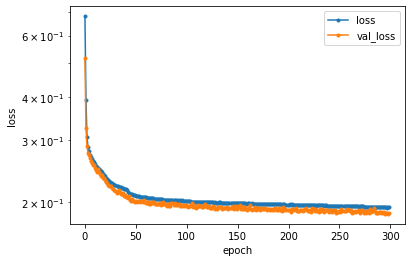

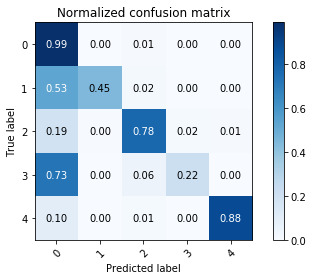

In [2]:
# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

config = {"optimizer": "Nadam",
          "loss": "categorical_crossentropy",
          "batch_size": 200,
          "val_split": 0.05,
          "epochs": 300,
          "verbose": 0,
          "patience": 20,
          "logdir": nofftpath}

layerlist = [
    ("conv", {"filters": 4, "width": 3}),
    ("conv", {"filters": 1, "width": 3}),
    ("maxpool", 2),
    ("conv", {"filters": 1, "width": 3}),
    ("conv", {"filters": 1, "width": 5}),
]
inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model = models.create_conv1d(inputsize, layerlist, ncategories)
history = train.train_print(model, inputs, labels, config)
train.plot_fit_history(history)

test_pred = np.argmax(model.predict(inputs["test"]), axis=1)
train.plot_cm(sparse_labels["test"], test_pred, classes=np.arange(5), normalize=True)

Let's try a deeper architecture, based loosely off of [WaveNet](https://arxiv.org/pdf/1609.03499.pdf):

Model: "conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 187, 32)      192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 187, 32)      2080        conv1d_10[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 187, 32)      0           conv1d_11[0][0]                  
_____________________________________________________________________________________________

Train acc: 0.98299336
Test acc: 0.97748035


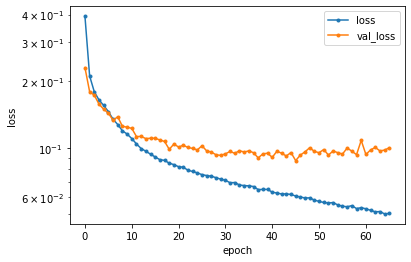

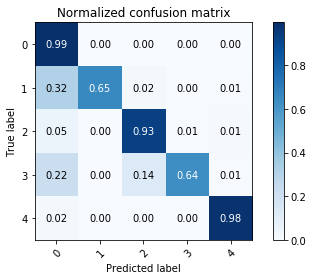

In [3]:
def filter_gate_multiply(output):
    filter_out = layers.Activation("tanh")(output)
    gate = layers.Activation("sigmoid")(output)
    
    return layers.Multiply()([filter_out, gate])

def residual_block(dilation_rate):
    return [
        ("startskip",),
        ("conv", {
            "filters": 32,
            "width": 2,
            "padding": "causal",
            "dilation": dilation_rate,
            "activation": "linear",
        }),
        (filter_gate_multiply,),
        ("conv", {
            "filters": 32,
            "width": 1,
            "padding": "causal",
            "activation": "linear",
        }),
        ("startskip",),
        ("endskip", -2),
    ]

def add_res_blocks(num_blocks, dilation_limit, layerlist):
    dilation_rate = 1
    for block_idx in range(num_blocks):
        if dilation_rate > dilation_limit:
            dilation_rate = 1
        layerlist.extend(residual_block(dilation_rate))
        dilation_rate *= 2

# Make the CNN, arbitrarily with four residual_blocks
num_blocks = 4
dilation_limit = np.floor(inputs["train"].shape[1] / 2)
layerlist_res = [("conv", {"filters": 32, "width": 5, "padding": "causal"})]
add_res_blocks(num_blocks, dilation_limit, layerlist_res)
for skip_idx in range(num_blocks):
    layerlist_res.append(("endskip",))
layerlist_res.extend([
    (layers.Activation("relu"),),
    ("conv", {"filters": 1, "width": 1, "padding": "causal"}),
])

config = {"optimizer": "Nadam",
          "loss": "categorical_crossentropy",
          "batch_size": 200,
          "val_split": 0.05,
          "epochs": 300,
          "verbose": 0,
          "patience": 20,
          "logdir": nofftpath}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model_res = models.create_conv1d(inputsize, layerlist_res, ncategories)
history = train.train_print(model_res, inputs, labels, config)
train.plot_fit_history(history)

test_pred = np.argmax(model_res.predict(inputs["test"]), axis=1)
train.plot_cm(sparse_labels["test"], test_pred, classes=np.arange(5), normalize=True)

We can see more overfitting occurring in the loss and validation loss plots; at the same time, the test accuracy is significantly better as well as the shape of the confusion matrix. Next up, maybe try some regularization, maybe with deeper architecture?